newyork taxt data analysis: https://github.com/swapnanilsharma/Taxi-demand-prediction-in-New-York-City/blob/master/NYC%20Final.ipynb

In [3]:
import matplotlib.pyplot as plt
import dask.dataframe as dd#similar to pandas
import pandas as pd
import datetime #Convert to unix time
import time #Convert to unix 
import numpy as np
import seaborn as sns#Plots
from sklearn.cluster import KMeans


In [4]:
# 데이터 열기
pd.set_option('display.max_columns', None)

month = pd.read_parquet('yellow_tripdata_2018-01.parquet',engine='pyarrow')

print(month)

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1               1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2               1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3               1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4               1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   
...           ...                  ...                   ...              ...   
8760682         1  2018-01-31 23:21:35   2018-01-31 23:34:20                2   
8760683         1  2018-01-31 23:35:51   2018-01-31 23:38:57                1   
8760684         2  2018-01-31 23:28:00   2018-01-31 23:37:09                1   
8760685         2  2018-01-31 23:24:40   2018-01-31 23:25:28                1   
8760686         2  2018-01-31 23:28:16   2018-01-31 23:28:38                1   

         trip_distance  Rat

In [5]:
# 널값 아닌 데이터 수
month.notnull().sum()

VendorID                 8760687
tpep_pickup_datetime     8760687
tpep_dropoff_datetime    8760687
passenger_count          8760687
trip_distance            8760687
RatecodeID               8760687
store_and_fwd_flag       8760687
PULocationID             8760687
DOLocationID             8760687
payment_type             8760687
fare_amount              8760687
extra                    8760687
mta_tax                  8760687
tip_amount               8760687
tolls_amount             8760687
improvement_surcharge    8760687
total_amount             8760687
congestion_surcharge          12
airport_fee                   12
dtype: int64

In [6]:
print(month.shape)

(8760687, 19)


In [7]:
# 상위 값 5개
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,NaN
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,NaN,NaN
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,NaN,NaN
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,NaN,NaN
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,NaN,NaN


1. time

In [8]:
# def convert_to_unix(s):

#     return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
    
def return_with_trip_times(month):
    # 탑승, 하차 시간 가져오기
    duration = month[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
    # unix time으로 변환
    duration_pickup = [x for x in duration['tpep_pickup_datetime'].values]
    duration_dropoff = [x for x in duration['tpep_dropoff_datetime'].values]
    
    # 이동 시간(분)
    onemin = pd.Timedelta(minutes=1)
    durations = (np.array(duration_dropoff) - np.array(duration_pickup)) / onemin
    #print(durations)

    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID', 'total_amount', 'tip_amount']]

    # 이동 시간과 이동 속도를 담은 새 데이터 생성    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    # /hour로 변환
    new_frame['speed'] = 60 * (new_frame['trip_distance']/new_frame['trip_times'])

    return new_frame

frame_with_durations = return_with_trip_times(month)


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

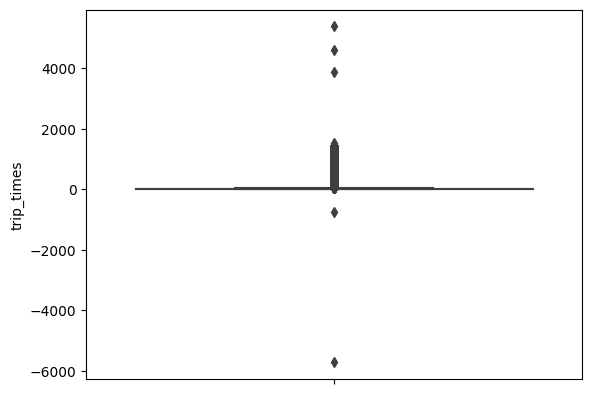

In [9]:
# 분단위
sns.boxplot(y="trip_times", data=frame_with_durations)
plt.show()

In [10]:
# 10%마다 해당되는 시간
for i in range(0, 100, 10):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])
# 양 끝쪽에 튀는 데이터 존재

0 percentile value is -5711.583333333333
10 percentile value is 3.8833333333333333
20 percentile value is 5.483333333333333
30 percentile value is 7.0
40 percentile value is 8.6
50 percentile value is 10.366666666666667
60 percentile value is 12.466666666666667
70 percentile value is 15.133333333333333
80 percentile value is 18.933333333333334
90 percentile value is 25.683333333333334
100 percentile value id  5382.066666666667


In [11]:
# 90%~100%마다 해당되는 시간
for i in range(90, 100):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])

90 percentile value is 25.683333333333334
91 percentile value is 26.75
92 percentile value is 27.95
93 percentile value is 29.366666666666667
94 percentile value is 31.016666666666666
95 percentile value is 33.03333333333333
96 percentile value is 35.6
97 percentile value is 39.083333333333336
98 percentile value is 44.416666666666664
99 percentile value is 54.46666666666667
100 percentile value id  5382.066666666667


In [12]:
# 0%~10%마다 해당되는 시간
for i in range(0, 11):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

0 percentile value is -5711.583333333333
1 percentile value is 1.1833333333333333
2 percentile value is 1.8666666666666667
3 percentile value is 2.283333333333333
4 percentile value is 2.5833333333333335
5 percentile value is 2.85
6 percentile value is 3.0833333333333335
7 percentile value is 3.3
8 percentile value is 3.5
9 percentile value is 3.7
10 percentile value is 3.8833333333333333


In [13]:
# 시간이 이상하게 튀는 값 삭제(12시간까지) -> 더 줄여도될듯?
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<120)]
print(frame_with_durations_modified.shape)

(8668281, 9)


In [14]:
var = frame_with_durations_modified["trip_times"].values
var = np.sort(var, axis=None)
print(var[0], var[-1])

1.0166666666666666 119.98333333333333


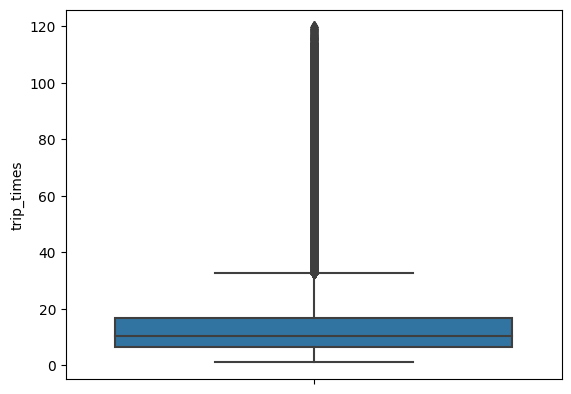

In [15]:
sns.boxplot(y="trip_times", data=frame_with_durations_modified)
plt.show()
# 왜 최댓값 30대???
# -> 1사분위수, 3사분위수에서 상자 길이의 1.5배 떨어진 거리가 최소, 최대값을 의미

c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


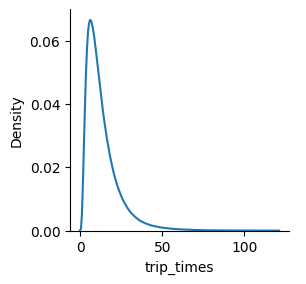

In [16]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "trip_times") \
    .add_legend()
plt.show()

In [17]:
import math
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\2641135077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


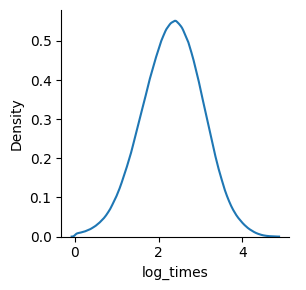

In [18]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "log_times") \
    .add_legend()
plt.show()

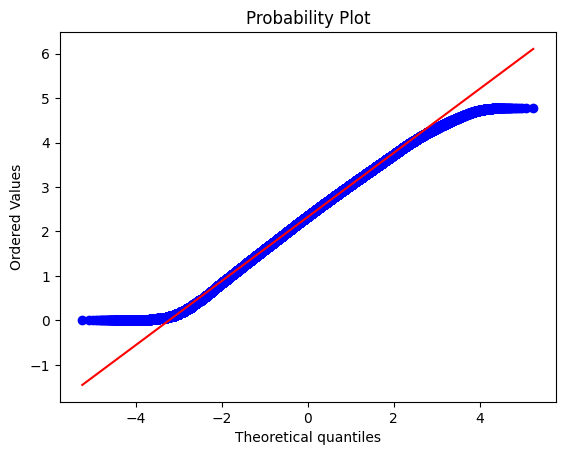

In [19]:
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()
# probplot ->  파란 점들이 빨간 선에 가까울수록 정규 분포를 띔

2. speed

C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3401238407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])


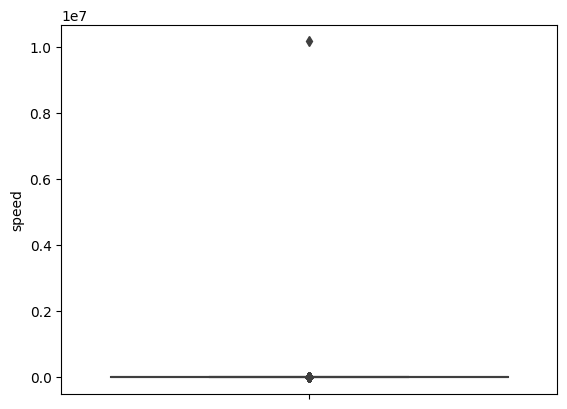

In [20]:
frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="speed", data=frame_with_durations_modified)
plt.show()

In [21]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.0
10 percentile value is 5.764705882352941
20 percentile value is 7.018050541516247
30 percentile value is 8.029739776951672
40 percentile value is 9.0
50 percentile value is 10.003597122302157
60 percentile value is 11.162790697674419
70 percentile value is 12.616822429906541
80 percentile value is 14.746987951807231
90 percentile value is 18.973116691285085
100 percentile value is 10181221.253731342


In [22]:
for i in range(90, 100):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝 쪽에 튀는 값 존재

90 percentile value is 18.973116691285085
91 percentile value is 19.69957081545064
92 percentile value is 20.526315789473685
93 percentile value is 21.484615384615385
94 percentile value is 22.599905526688712
95 percentile value is 23.905740181268886
96 percentile value is 25.493050959629382
97 percentile value is 27.491740787801778
98 percentile value is 30.23821339950372
99 percentile value is 34.41370869033047
100 percentile value is 10181221.253731342


In [23]:
for i in range(0, 11):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝쪽에 튀는 값 존재

0 percentile value is 0.0
1 percentile value is 3.2323232323232327
2 percentile value is 3.858520900321543
3 percentile value is 4.259541984732825
4 percentile value is 4.568527918781726
5 percentile value is 4.826498422712934
6 percentile value is 5.051449953227316
7 percentile value is 5.254054054054055
8 percentile value is 5.4362416107382545
9 percentile value is 5.60698689956332
10 percentile value is 5.764705882352941
100 percentile value is 10181221.253731342


In [24]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is", var[-1])

99.0 percentile value is 34.41370869033047
99.1 percentile value is 34.985915492957744
99.2 percentile value is 35.614629794826044
99.3 percentile value is 36.3082191780822
99.4 percentile value is 37.05146036161335
99.5 percentile value is 37.916666666666664
99.6 percentile value is 38.925714285714285
99.7 percentile value is 40.15384615384615
99.8 percentile value is 41.72117039586919
99.9 percentile value is 44.22786547700755
100 percentile value is 10181221.253731342


In [25]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.speed>0) & (frame_with_durations_modified.speed < 50)]

In [26]:
# 평균 속도
sum(frame_with_durations_modified['speed']) / float(len(frame_with_durations_modified['speed']))

11.481654321751463

3. trip distance

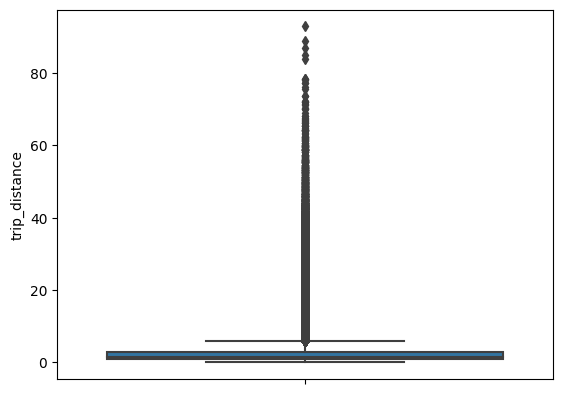

In [27]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [28]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.83
30 percentile value is 1.04
40 percentile value is 1.3
50 percentile value is 1.57
60 percentile value is 1.91
70 percentile value is 2.48
80 percentile value is 3.44
90 percentile value is 6.31
100 percentile value is 92.93


In [29]:
for i in range(90, 100):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

90 percentile value is 6.31
91 percentile value is 6.96
92 percentile value is 7.73
93 percentile value is 8.6
94 percentile value is 9.43
95 percentile value is 10.32
96 percentile value is 11.46
97 percentile value is 13.63
98 percentile value is 17.04
99 percentile value is 18.7
100 percentile value is 92.93


In [30]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.7
99.1 percentile value is 18.94
99.2 percentile value is 19.2
99.3 percentile value is 19.5
99.4 percentile value is 19.9
99.5 percentile value is 20.3
99.6 percentile value is 20.8
99.7 percentile value is 21.35
99.8 percentile value is 22.23
99.9 percentile value is 25.16
100 percentile value is  92.93


In [31]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.trip_distance>0) & (frame_with_durations_modified.trip_distance<30)]

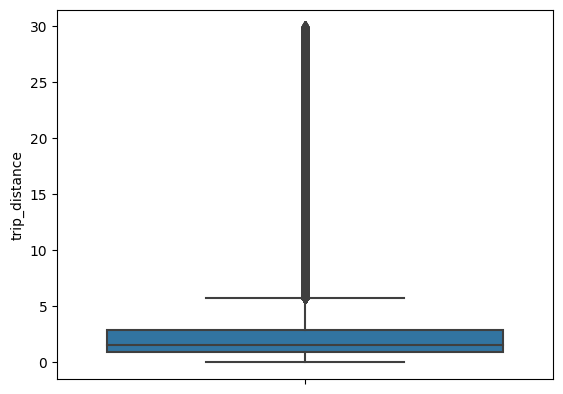

In [32]:
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

4. total fare

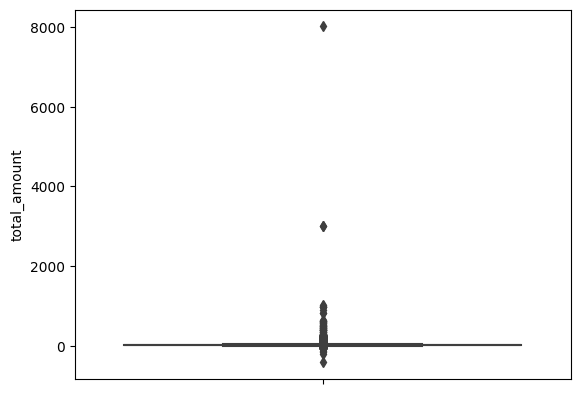

In [33]:
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [34]:
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -420.8
10 percentile value is 6.62
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.96
50 percentile value is 11.3
60 percentile value is 12.95
70 percentile value is 15.3
80 percentile value is 18.8
90 percentile value is 27.8
100 percentile value is  8016.8


In [35]:
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.8
91 percentile value is 29.75
92 percentile value is 32.2
93 percentile value is 35.56
94 percentile value is 39.12
95 percentile value is 43.06
96 percentile value is 47.47
97 percentile value is 53.47
98 percentile value is 61.32
99 percentile value is 70.26
100 percentile value is  8016.8


In [36]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.26
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 70.27
99.4 percentile value is 73.06
99.5 percentile value is 73.2
99.6 percentile value is 75.67
99.7 percentile value is 77.76
99.8 percentile value is 84.8
99.9 percentile value is 98.88
100 percentile value is  8016.8


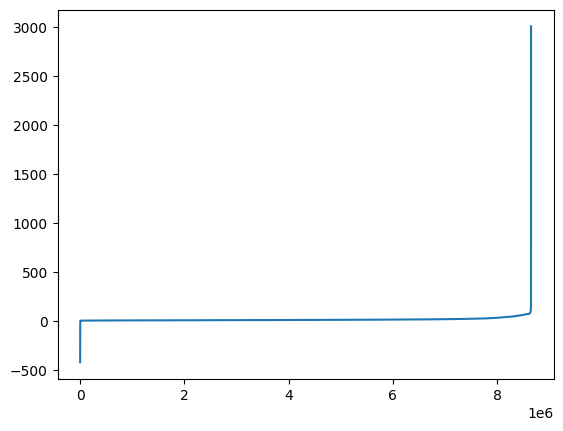

In [37]:
plt.plot(var[:-2])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

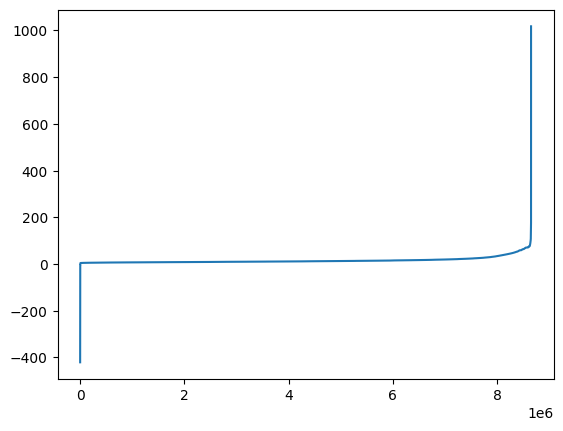

In [38]:
plt.plot(var[:-3])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

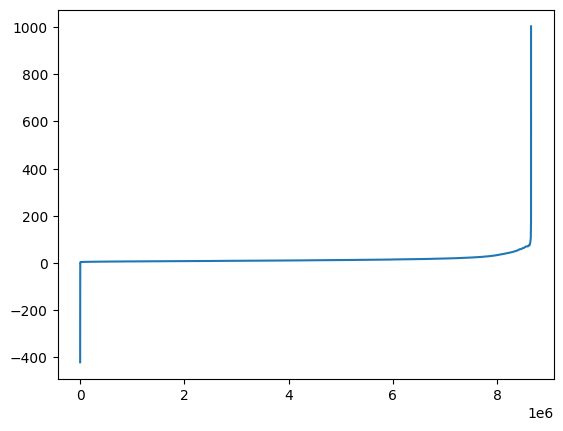

In [39]:
plt.plot(var[:-4])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

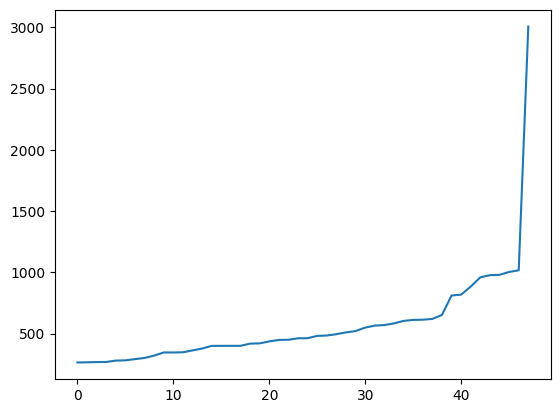

In [40]:
plt.plot(var[-50:-2])
plt.show()
# 1000언저리에서 끊어야함

5. tip_amount

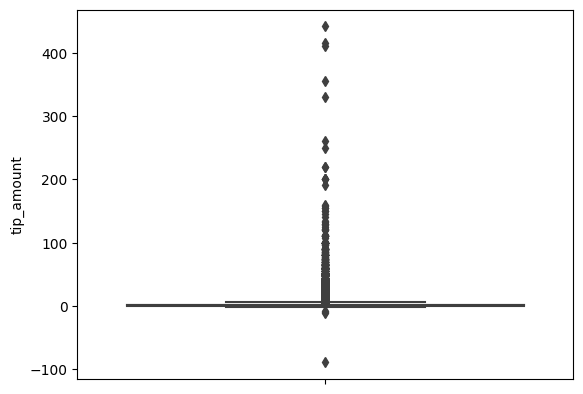

In [41]:
sns.boxplot(y="tip_amount", data =frame_with_durations_modified)
plt.show()

In [42]:
for i in range(0,100,10):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -88.8
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 1.0
50 percentile value is 1.4
60 percentile value is 1.76
70 percentile value is 2.06
80 percentile value is 2.7
90 percentile value is 3.99
100 percentile value is  441.71


In [43]:
for i in range(90,100,1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.8
91 percentile value is 29.75
92 percentile value is 32.2
93 percentile value is 35.56
94 percentile value is 39.12
95 percentile value is 43.06
96 percentile value is 47.47
97 percentile value is 53.47
98 percentile value is 61.32
99 percentile value is 70.26
100 percentile value is  8016.8


In [44]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.26
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 70.27
99.4 percentile value is 73.06
99.5 percentile value is 73.2
99.6 percentile value is 75.67
99.7 percentile value is 77.76
99.8 percentile value is 84.8
99.9 percentile value is 98.88
100 percentile value is  8016.8


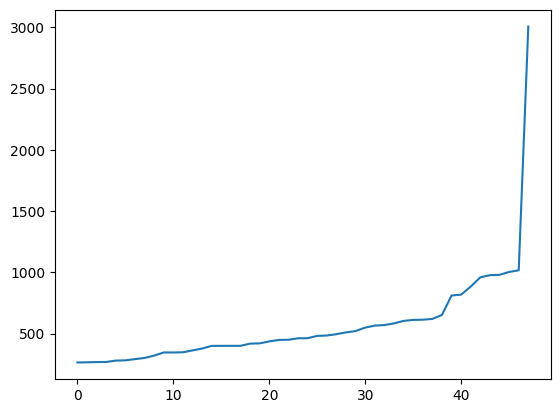

In [45]:
plt.plot(var[-50:-2])
plt.show()
# 1100언저리에서 끊어야함

In [46]:
# 1. 이상한 시간
# 2. 이상한 속도
# 3. 이상한 거리
# 4. 이상한 비용
# 5. 이상한 팁
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print("총 데이터 수 = ", a)

    # 시간
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    c = temp_frame.shape[0]
    print ("시간 튀는 값의 개수:",(a-c))
    
    # 거리
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    d = temp_frame.shape[0]
    print ("거리 튀는 값의 개수:",(a-d))

    # 속도
    temp_frame = new_frame[(new_frame.speed <= 50) & (new_frame.speed >= 0)]
    e = temp_frame.shape[0]
    print ("속도 튀는 값의 개수",(a-e))

    # 비용
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("비용 튀는 값의 개수:",(a-f))

    # 팁
    temp_frame = new_frame[(new_frame.tip_amount <1100) & (new_frame.tip_amount >0)]
    f = temp_frame.shape[0]
    print ("팁 튀는 값의 개수:",(a-f))

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    new_frame = new_frame[(new_frame.speed < 50) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    new_frame = new_frame[(new_frame.tip_amount <1100) & (new_frame.tip_amount >0)]

    print("전체 삭제 된 데이터 수", a-new_frame.shape[0])
    print("---")
    return new_frame

In [55]:
print("2018-01 데이터 제거 현황")
print("---")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("튀는 값 제거하고 남은 비율", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

2018-01 데이터 제거 현황
---
총 데이터 수 =  8760687
시간 튀는 값의 개수: 25045
거리 튀는 값의 개수: 58699
속도 튀는 값의 개수 16996
비용 튀는 값의 개수: 5336
팁 튀는 값의 개수: 2895981
전체 삭제 된 데이터 수 2927664
---
튀는 값 제거하고 남은 비율 0.66581798893169



-----------------------------------------------------------------
1. 시간 구간 구해서 그룹핑(클러스터링은 이미 되어 있으므로 생략)

In [73]:
# Refer:https://www.unixtimestamp.com/
# 1514732400 : 2018-01-01 00:00:00 
# 1517410800 : 2018-02-01 00:00:00 
# 1519830000 : 2018-03-01 00:00:00
# 1522508400 : 2018-04-01 00:00:00 
# 1525100400 : 2018-05-01 00:00:00 
# 1527778800 : 2018-06-01 00:00:00

# 1546268400 : 2019-01-01 00:00:00 
# 1548946800 : 2019-02-01 00:00:00 
# 1551366000 : 2019-03-01 00:00:00
# 1554044400 : 2019-04-01 00:00:00 
# 1556636400 : 2019-05-01 00:00:00 
# 1559314800 : 2019-06-01 00:00:00

def add_pickup_bins(frame, month, year):
    # 탑승 시간에 대한 배열
    unix_pickup_times = [i for i in frame['pickup_times'].values]
    unix_times = [[1514732400, 1517410800, 151983000, 1522508400, 1525100400, 1527778800], \
        [1546268400, 1548946800, 1551366000, 1554044400, 1556636400, 1559314800]]

    # 해당하는 년도와 월에 대한 시간
    start_pickup_unix = unix_times[year-2018][month-1]
    # (int((i-start_pickup_unix)/600)+33) : est 표준 시간 -> gmt 표준 시간(미국 동부)
    # 해당 년도 월에 대해서 10분 간격으로 나누기
    tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [74]:
jan_2018_frame = add_pickup_bins(frame_with_durations_outliers_removed, 1, 2018)

C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


In [175]:
# 2018년도 1월 시간과 지역별 그룹화
jan_2018_groupby = jan_2018_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins'])

In [77]:
jan_2018_frame.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,tip_amount,trip_times,pickup_times,speed,pickup_bins
2,2,0.8,262,141,8.30,1.00,5.916667,2018-01-01 00:08:26,8.112676,87
4,2,2.5,246,239,16.55,2.75,17.800000,2018-01-01 00:09:18,8.426966,87
6,2,1.7,50,239,12.35,2.05,10.266667,2018-01-01 00:38:08,9.935065,90
7,1,0.7,239,238,6.30,1.00,2.400000,2018-01-01 00:49:29,17.500000,91
8,1,1.0,238,24,8.50,1.70,4.450000,2018-01-01 00:56:38,13.483146,92


In [183]:
k = jan_2018_groupby[jan_2018_groupby['trip_distance'] == 0.8]
print(k)

Empty DataFrame
Columns: [trip_distance]
Index: []


In [80]:
# 앞까지 했던 방식을 2019-1, 2019-2, 2019-3에 대해 똑같이 적용
def datapreparation(month, month_no, year_no):

    print("return_with_trip_times..")
    frame_with_durations = return_with_trip_times(month)

    print("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print('Final groupying')
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed, month_no, year_no)
    final_groupby_frame = final_updated_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()

    return final_updated_frame, final_groupby_frame


month_jan_2019 = pd.read_parquet('yellow_tripdata_2019-01.parquet',engine='pyarrow')
month_feb_2019 = pd.read_parquet('yellow_tripdata_2019-02.parquet',engine='pyarrow')
month_mar_2019 = pd.read_parquet('yellow_tripdata_2019-03.parquet',engine='pyarrow')

jan_2019_frame, jan_2019_groupby = datapreparation(month_jan_2019, 1, 2019)
feb_2019_frame, feb_2019_groupby = datapreparation(month_feb_2019, 2, 2019)
mar_2019_frame, mar_2019_groupby = datapreparation(month_mar_2019, 3, 2019)

return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Remove outliers..
총 데이터 수 =  7696617
시간 튀는 값의 개수: 27889
거리 튀는 값의 개수: 58240
속도 튀는 값의 개수 15120
비용 튀는 값의 개수: 8793
팁 튀는 값의 개수: 2438772
전체 삭제 된 데이터 수 2474908
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Remove outliers..
총 데이터 수 =  7049370
시간 튀는 값의 개수: 25487
거리 튀는 값의 개수: 52741
속도 튀는 값의 개수 13949
비용 튀는 값의 개수: 11258
팁 튀는 값의 개수: 2106999
전체 삭제 된 데이터 수 2138499
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Remove outliers..
총 데이터 수 =  7866620
시간 튀는 값의 개수: 27494
거리 튀는 값의 개수: 57473
속도 튀는 값의 개수 15025
비용 튀는 값의 개수: 13582
팁 튀는 값의 개수: 2408533
전체 삭제 된 데이터 수 2444621
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_20936\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


2. smoothing(평활화)
-> 데이터가 없는 구간 확인
-> 0으로 채워주고, 평균값으로 설정

In [132]:
print(jan_2018_groupby)

                          trip_distance
PULocationID pickup_bins               
1            107                      1
             124                      1
             267                      1
             704                      1
             720                      1
...                                 ...
265          4507                     1
             4526                     1
             4531                     2
             4539                     1
             4548                     1

[304738 rows x 1 columns]


In [145]:
# 각 지역마다 데이터가 존재하는  시간대 리스트 구하기

def return_unq_pickup_bins(frame):
    values = []
    for i in range(1, 266): # 265개의 PULocationID
        new = frame[frame['PULocationID'] == i] # 지역별
        list_unq = list(set(new['pickup_bins'])) # pickup이 존재하는 시간 리스트
        list_unq.sort()
        values.append(list_unq) # 시간대마다 values에 누적
    return values

In [146]:
#jan
jan_2018_unique = return_unq_pickup_bins(jan_2018_frame)
jan_2019_unique = return_unq_pickup_bins(jan_2019_frame)

#feb
feb_2019_unique = return_unq_pickup_bins(feb_2019_frame)

#march
mar_2019_unique = return_unq_pickup_bins(mar_2019_frame)

In [147]:
# 31일 * 24시간 * 60분 / 10분 = 4464
for i in range(1, 266):
    print(i, "번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수", 4464-len(set(jan_2018_unique[i-1])))
    print("-"* 60)

1 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4419
------------------------------------------------------------
2 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4461
------------------------------------------------------------
3 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4454
------------------------------------------------------------
4 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 928
------------------------------------------------------------
5 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4464
------------------------------------------------------------
6 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4450
------------------------------------------------------------
7 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 1774
------------------------------------------------------------
8 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4429
------------------------------------------------------------
9 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4451
------------------------------------------------------------
10 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 3493
-------------------------------

지역간 편차 큰거 같음

In [148]:
# 탑승 기록이 없으면 0으로 채우기
# count_values: 각 지역 각 10분 간격에 픽업 수
# values: 픽업 기록이 있는 간격의 set
def fill_missing(count_values, values):
    smoothed_regions = []
    ind = 0
    for r in range(1, 266): # 각 구역마다
        smoothed_bins = []
        for i in range(4464):
            if i in values[r-1]: # interval 안에 탑승 기록이 있으면
                smoothed_bins.append(count_values[ind])
                ind += 1
            else: # interval 안에 탑승 기록이 없으면
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [161]:
# 빈값을 평균으로 채우기
# interval 안에 pickup 기록이 없다면
# pickup 기록이 있는 자신과 가장 가까운 양 끝값을 이용하여 평균을 구함
def smoothing(count_values,values):
    smoothed_regions=[] # 각 지역마다 최종 smoothed 값을 저장할 리스트
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,266): # 지역마다
        smoothed_bins=[] # 최종 smoothed 값을 저장할 리스트
        repeat=0
        for i in range(4464): # interval 마다
            if repeat!=0: # 같은 interval을 여러 번 계산 방지
                repeat-=1
                continue
            if i in values[r-1]: # interval 안에 픽업 기록이 존재하면
                smoothed_bins.append(count_values[ind]) # interval을 리스트에 추가
            else:
                if i!=0: # 첫 구간이 아니면 (left~rigth or right~끝)
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]: # interval안에 픽업이 없는 경우 평균값으로 채워져야 하므로 넘어감
                            continue
                        else:
                            right_hand_limit=j # interval안에 픽업이 존재하는 경우에 right_limit이 됨
                            break
                    if right_hand_limit==0:
                    #Case 1: right~끝
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464): # right~끝까지 평균으로 채우기              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: left~right
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1): # left~right까지 평균으로 채우기   
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: 처음~right
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j # interval 안에 픽업이 존재하는 경우 right가 됨
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):# 처음~left까지 평균으로 채우기
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [162]:
jan_2018_fill = fill_missing(jan_2018_groupby['trip_distance'].values , jan_2018_unique)

In [164]:
jan_2018_smooth = smoothing(jan_2018_groupby['trip_distance'].values, jan_2018_unique)

In [166]:
# 2018 1월 = 4464
# 2019 1월 = 4464
# 2019 2월 = 4032
# 2019 3월 = 4320
# 4464 * 255 = 1,182,960
print("모든 클러스터 사이에 10분 interval 수", len(jan_2018_fill))

모든 클러스터 사이에 10분 interval 수 1182960


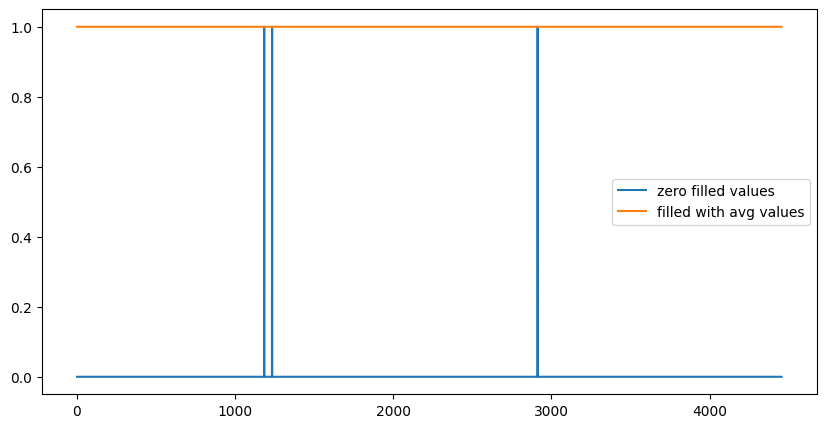

In [167]:
plt.figure(figsize=(10, 5))
plt.plot(jan_2018_fill[4464:8920], label = "zero filled values")
plt.plot(jan_2018_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()